# New poems of Rupi Kaur 

This notebook presents an artificial intelligence (AI) project that generates new poems using GPT-2, a language generation model. The project is based on the poems of Rupi Kaur, a popular contemporary poet known for her simple yet powerful language and themes of love, self-empowerment, and healing. The poems of Rupi Kaur that are used in this project are from the books: *The sun and her flowers* and *Milk and honey*. The goal of the project is to explore the potential of AI to generate new poetry that is stylistically similar to Kaur's work and to investigate the creative possibilities of AI-generated poetry. The notebook will provide an overview of the project's methodology, results, and conclusions. 

## References used in this project
During the creation of this Jupyter notebook, multiple resources have been consulted. The resources that contrubuted the most during the project are the following:   
- The code used for importing all of the libraries and functions, visualizing and training the code are from the lessons and they are adjusted to the needs of the project. 
- The inspiration for the project, preparing the data set, training the model and generated the new poems are from: Scott Duda https://scottmduda.medium.com/generating-an-edgar-allen-poe-styled-poem-using-gpt-2-289801ded82c. The code is adjusted 
- The code used for tokenizing and better understanding generating poems with pre-trained models are from: Jesse Chan https://keras.io/examples/generative/text_generation_gpt/
- For deeper understanding the information about machine learning and how to build and train a model the book the book: *Deep Learning with Python* by François Chollet was consulted 

In [5]:
#Transformers need to be installed to be able to use languages models later in this project
!pip install transformers
!pip install torch

In [6]:
#First, all of the libraries and functions that will be need are loaded to explorer, visualize and train the model and define some constants that are being used.
import numpy as np
import pandas as pd 

import random
import time
import datetime

import seaborn as sns #this is the plotting library I'll be using 
import matplotlib.pyplot as plt #we need Matplotlib for setting the labels in the Seaborn graphs
import math
from sklearn.linear_model import LinearRegression #all important of sk-learn

import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, random_split, DataLoader, RandomSampler, SequentialSampler

In [9]:
# Load the data from the Excel file if running on google colab
#from google.colab import drive
#drive.mount('/content/gdrive')
# the file is in the drive
#poems_df = pd.read_excel('/content/gdrive/My Drive/RupiKaur.xlsx')

poems_df = pd.read_excel("RupiKaur.xlsx")
poems_df.head()

#Now the basis of this project in imported.

,Author,Book,Poem,Kolom1
0,Rupi Kaur,The sun and her flowers,bees came for honey flowers giggled as they un...,NaN
1,Rupi Kaur,The sun and her flowers,on the last day of love my heart cracked insid...,NaN
2,Rupi Kaur,The sun and her flowers,i spent the entire night casting spells to bri...,NaN
3,Rupi Kaur,The sun and her flowers,i stuffed a towel at the foot of every door le...,NaN
4,Rupi Kaur,The sun and her flowers,you left and i wanted you still yet i deserved...,NaN


In [10]:
poems_df['totalwords'] = poems_df['Poem'].str.count(' ') + 1
 
# Calculating which poem contains the most and least poems
biggest=(poems_df.totalwords.max())
smallest=(poems_df.totalwords.min())

print('The biggest poem contains', biggest, 'words.')
print('The smallest poem contains', smallest, 'words.')

The biggest poem contains 643 words.
The smallest poem contains 5 words.


The median amount of words in a poem is: 26.0 words
The mean amount of words in a poem is: 57.44126074498568 words 


C:\Users\ilsed\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


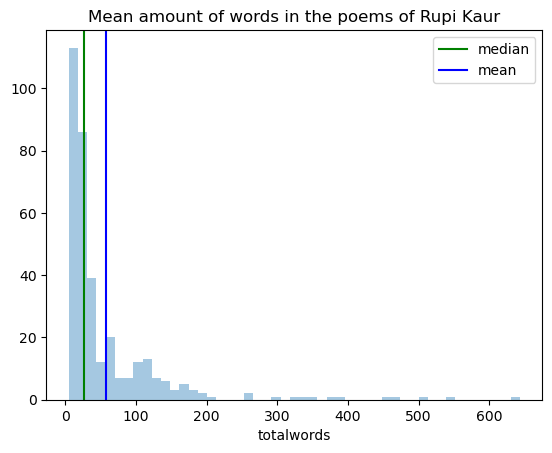

In [11]:
mean_size = poems_df['totalwords'].mean()
median_size = poems_df['totalwords'].median()

print(f'The median amount of words in a poem is: {median_size} words')
print(f'The mean amount of words in a poem is: {mean_size} words ')

sns.distplot(poems_df['totalwords'].dropna(), kde=False)
plt.title('Mean amount of words in the poems of Rupi Kaur')
plt.axvline(median_size, 0, 100, color='green', label='median') #This adds a vertical line at x-position median_size, from y = 0 to y = 100 
plt.axvline(mean_size, 0, 100, color='blue', label='mean') 
plt.legend() #This adds a legend. It works automatically because the labels are set in the previous lines
plt.show()

Some things to note about this distribution:

It has 1 peaks (unimodal) The words have a 'tail' on the right which makes this graph (right-skewed) Because the mean is higher than the median and the median is higher than the mode.

The data is as expedted not normally distributed.

I want to take a look at the mean and median and plot them in the graph



C:\Users\ilsed\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


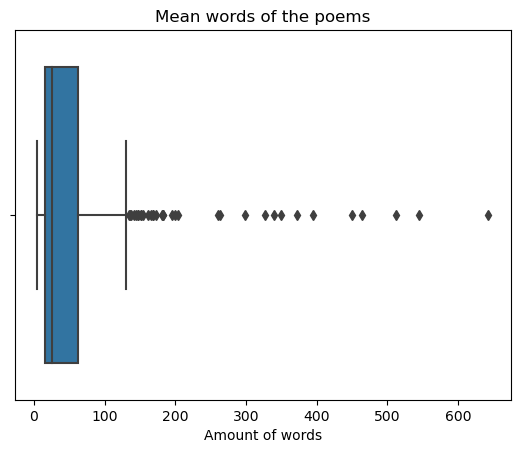

In [12]:
sns.boxplot(poems_df['totalwords'])
plt.title('Mean words of the poems')
plt.xlabel('Amount of words')
plt.show()

In [13]:
poems_df['totalwords'].describe()

count    349.000000
mean      57.441261
std       83.099823
min        5.000000
25%       16.000000
50%       26.000000
75%       62.000000
max      643.000000
Name: totalwords, dtype: float64

It is observed that 75% of the poems contain 62 words or less, while the remaining 25% contain between 62 and 643 words. This indicates that a majority of the poems are relatively short, with only a limited number being considered "bigger".

A boxplot reveals the presence of several outliers, specifically those poems containing approximately more than 125 words.

This information will be used in future efforts to improve the quality of generated poems.

In earlier analyses, the entire dataset of poems was examined. However, it is important to note that the dataset is composed of two books. Further analyses will focus on the differences between these two books.

In [14]:
# Discovering how may poems each book have
tsanhf=(poems_df['Book'].value_counts()['The sun and her flowers'])
mah=(poems_df['Book'].value_counts()['Milk and honey'])

print('The sun and her flowers contain', tsanhf, 'poems.')
print('Milk and honey contain', mah, 'poems.')

The sun and her flowers contain 214 poems.
Milk and honey contain 133 poems.


<AxesSubplot:xlabel='Book', ylabel='totalwords'>

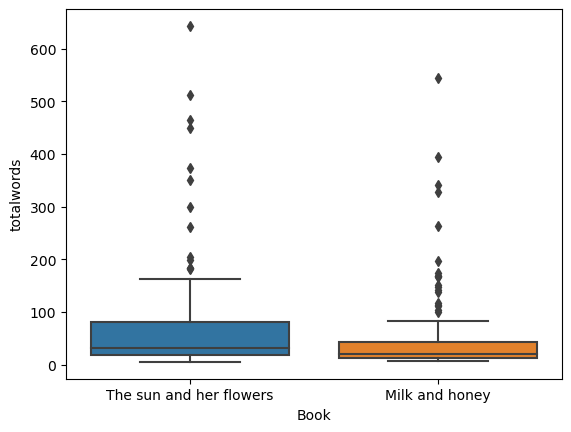

In [15]:
sns.boxplot(data=poems_df, x="Book", y="totalwords")

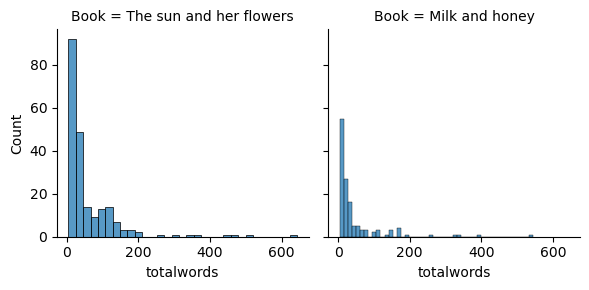

In [16]:
g = sns.FacetGrid(poems_df, col="Book")
g.map(sns.histplot, "totalwords")

It can be seen that the book Milk and honey contains less poems, there is a difference of 81 poems. Besides the difference in amount of poems, the book Milk and honey also contains less words and has less outliers.

A boxplot reveals that the median and mean of words per poem is closer in Milk and honey. The median and mean of words per poem is bigger in The sun and her flowers the standard deviation is bigger here.



In [ ]:
RANDOM_SEED = 42
BATCH_SIZE = 2 #the total number of training examples present in a single batch
EPOCHS = 8 #the times an entire dataset is passed forward and backward through the neural network
MAX_LEN = 125 #to generate better poems the max lenght is set to 125, so the model will not generate poems that fall under the catogorie "ourliers"

## Tokenization
Preprocessing the dataset by tokenizing 

In [ ]:
# a GPT-2 tokenizer is being instantiated. This initializes the tokenizer with the pre-trained vocabulary and tokenization rules of the GPT-2 model.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
special_tokens_dict = {
    'bos_token': '<BOS>', 
    'eos_token': '<EOS>', 
    'pad_token': '<PAD>'}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict) #returns the number of added tokens

In [ ]:
class PoemsDataset(Dataset): # prepare and format the input data for training and evaluating
    def __init__(self, data, tokenizer, gpt2_type='gpt2', max_length=MAX_LEN): # the input data is tokenized using the tokenizer 
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []
        
        for i in data:
            encodings_dict = tokenizer('<BOS>' + i + '<EOS>',
                                     truncation=True,
                                     max_length=max_length,
                                     padding='max_length')

            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self): # returns the number of samples in the dataset
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]
        
poems_dataset = PoemsDataset(poems_df['Poem'].values, tokenizer, max_length=MAX_LEN) # This creates the dataset object that can be used for training or evaluating models.

## Preparing data for training and validation of model
The purpose of this code is to prepare the data for training and validation of a model.

In [ ]:
def train_val_split(split, dataset): # takes in a dataset and a split ratio, and is used to split the dataset into a train and validation set
    train_size = int(split * len(dataset))
    val_size = len(dataset) - train_size
    return train_size, val_size
poems_train_size, poems_val_size = train_val_split(0.8, poems_dataset)
poems_train_dataset, poems_val_dataset = random_split(poems_dataset, [poems_train_size, poems_val_size])

In [ ]:
torch.cuda.manual_seed_all(RANDOM_SEED) #CUDA is used to make sure that the computations done on the GPU are reproducible.
random.seed(RANDOM_SEED) #ensures that the results of the computations will be reproducible across different runs of the program, allowing for better analysis
np.random.seed(RANDOM_SEED) #initialization of model parameters
torch.manual_seed(RANDOM_SEED)

In [ ]:
# This code creates two PyTorch data loaders, poems_train_dataloader and poems_val_dataloader, for the poems_train_dataset and poems_val_dataset
poems_train_dataloader = DataLoader(poems_train_dataset,
                              sampler=RandomSampler(poems_train_dataset), # this ensures that the model sees different examples in each epoch
                              batch_size=BATCH_SIZE)

poems_val_dataloader = DataLoader(poems_val_dataset,
                            sampler=SequentialSampler(poems_val_dataset), # valadation uses the SequentialSampler class, this is useful for evaluation as it allows us to see the model's performance on a dataset in a deterministic way
                            batch_size=BATCH_SIZE)

In [ ]:
# helper function for logging time, takes in the elapsed time in seconds
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

# hyperparameters
learning_rate = 1e-4
eps = 1e-8
warmup_steps = 50

# creates text generation seed prompt
device = torch.device('cuda')

prompt = "<BOS>" # the special token that indicates the beginning of a sequence
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

## Fine-tuning the GPT-2 model
Fine-tuning the pre-trained GPT-2 model with the poems of Rupi Kaur.

In [ ]:
# a configuration object is created for the GPT-2 model, and initializing the model with pre-trained weights from the 'gpt2' model.
configuration = GPT2Config(vocab_size=len(tokenizer), n_positions=MAX_LEN).from_pretrained('gpt2', output_hidden_states=True)

poem_model = GPT2LMHeadModel.from_pretrained('gpt2', config=configuration) #creating a GPT-2LMHeadModel object using the specified configuration and pre-trained weights
poem_model.resize_token_embeddings(len(tokenizer))

poem_model.cuda() # moving the model to the GPU for faster training
optimizer = AdamW(poem_model.parameters(), lr=learning_rate, eps=eps)

totalSteps = len(poems_train_dataloader) * EPOCHS #creating a scheduler to adjust the learning rate during training
scheduler = get_linear_schedule_with_warmup(optimizer, # gradually increases the learning rate during the first warmup_steps, then keeps it constant
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=totalSteps)

startTime = time.time()
poem_model = poem_model.to(device)

#In each epoch, the model's parameters are updated by passing the input, labels, and masks through the model and computing the loss. The gradients are then calculated and the optimizer takes a step. The scheduler also takes a step to adjust the learning rate
for epoch_i in range(0, EPOCHS):

    print(f'Epoch {epoch_i + 1} of {EPOCHS}')

    t0 = time.time()
    total_train_loss = 0
    poem_model.train()

    for step, batch in enumerate(poems_train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        poem_model.zero_grad()        

        outputs = poem_model(b_input_ids,
                                    labels=b_labels,
                                    attention_mask=b_masks,
                                    token_type_ids=None)

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(poems_train_dataloader) #calculating the training loss       
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch Training Time: {training_time}')

    t0 = time.time()

    poem_model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in poems_val_dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():        

            outputs  = poem_model(b_input_ids,
                                         attention_mask=b_masks,
                                         labels=b_labels)

            loss = outputs[0]  

        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(poems_val_dataloader) #calculating the valadation loss


    print(f'Average Validation Loss: {avg_val_loss}')

print(f'Total Training Time: {format_time(time.time()-startTime)}')

torch.save(poem_model.state_dict(), '/content/gdrive/My Drive/' + 'poem_model.pth')

## Results of training
The results of the last training 

Epoch 1 of 8
Average Training Loss: 10.282820536409105. Epoch Training Time: 0:00:04
Average Validation Loss: 2.2413592073652477

Epoch 2 of 8
Average Training Loss: 2.026493946143559. Epoch Training Time: 0:00:04
Average Validation Loss: 1.8695632484224107

Epoch 3 of 8
Average Training Loss: 1.7970576456614904. Epoch Training Time: 0:00:04
Average Validation Loss: 1.7665826214684381

Epoch 4 of 8
Average Training Loss: 1.678679405791419. Epoch Training Time: 0:00:04
Average Validation Loss: 1.7220232254929013

Epoch 5 of 8
Average Training Loss: 1.5901322398866926. Epoch Training Time: 0:00:04
Average Validation Loss: 1.6928914222452376

Epoch 6 of 8
Average Training Loss: 1.544407148020608. Epoch Training Time: 0:00:04
Average Validation Loss: 1.667143036921819

Epoch 7 of 8
Average Training Loss: 1.5098074998174396. Epoch Training Time: 0:00:04
Average Validation Loss: 1.6705826653374567

Epoch 8 of 8
Average Training Loss: 1.483797058888844. Epoch Training Time: 0:00:04
Average Validation Loss: 1.656847957107756

Total Training Time: 0:00:33

###### The average training loss measures the average error of the model's predictions on the training data, while the average validation loss measures the average error of the model's predictions on a separate validation set. 
**The training loss and validation is a bit high especially in the first epoch, this can indicate that the model is not at its best at making predictions on both the training and validation data. The Training an test loss is also higher of the lenght. In the first epoch the poems longer than 125 words are also removed. 
The validation loss is not significantly higher than the training loss, this indicates that the model is not overfitting.**

## Generating the new poems
The code sets the model to evaluation mode by calling the eval() method on the poems_model.

In [ ]:
# this code sets the model to evaluation mode, generates new poem sequences based on the seed prompt using the generate method of the model, and prints the generated poems by decoding the token IDs back to the original text
poem_model.eval() #sets model to evaluation mode

sample_outputs = poem_model.generate(   # generates new poems based on the seed prompt created earlier.
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length=63,
                                top_p=0.95, 
                                num_return_sequences=10
                                )

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

## Some results 
In the document "All generated poems" is an overview of all poems that were saved after generating. The first generated poems were not saved, the lines were mostly empty, single letters and eventially single words. After changing the code a few times I succesfully generated some poems.

In this notebook a few will be shared. First the worst three are shared. And as last the best bigger poems and the best smaller poems (in my opinion).

#### The worst 3 generated poems
1. 
2. -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
3. to be made whole—that is their name— — that is their name— — that is their love— — that isn’t their name— — that doesn’t bother’t me— — that does’t bother me— — that is not my name— ’tries to’t try to’t understand me— — that’s what’s so important’s to you— — that is not my name— ’tries to leave me— — that is not my home— ’tries to be a man— ’tries to protect us— — is not your home— ’tries to tell you— — that isn’t mine— — that is your name— ’tries to give you satisfaction— ’tries to teach you— — that makes sense’t— ’tries to take you—’s place— ’tries to see you’s face— ’tries— — and’tries to keep you— ’tries— ——in a dream’t— —’tries to keep me— ’tries— ’tries— ——until you’t’d—’d— ’tried to tell me— ’tried to tell me— ’tried’t— ’tried’t— —to’t take you—and’tll’t’d— ’tried— ’tried to tell me—’tried to tell me— —’tried— —and’tried—’d— ’tried’t— ’tried— ’tried—and’tried— and’tried to’t’d— ’tried’t— —to look for the perfect partner—and’tried’t— —to search for a way out’t— ’tried—to find your lover—and’t’d— ’tried’t— ’tried— to find your magic— ’tried’t— ’tried— ’tried’t— to find the perfect woman—and’t’d— ’tried—’tried— ’tried to find you—and’t’d—’d’d’d ’tried—’tried’t— to carry you—and�

#### Best bigger poems
1. i tell you it is okay as you are living your life in the most unbreakable frame of mind you can ever feel like living with an    emotion that will
   i am a little bit broken by these flowers i am so happy i am so relieved when our bodies meet at the same time
2. toward the end of the conversation i am listening to you in your ears too. as if listening to you on your skin is a    reflection of what you want. the sun is a reflection on your body like it was a reflection of what you were. i am growing more than you have seen before.
3. the time between the death of one and the end of another is the age of doubt when the answer arrives and the question comes back that questions always remain unanswerable when the question arrives - to the question of how we ever learned the answer


#### Best smaller poems 
1. the whole universe- is so empty
2. a second to rise and fall i’m placing myself in his lap - i do not wish there were flowers
3. this is not how it is supposed to be happening 
   the sun will rise again



## Conclusion

In conclusion, training a model to generate poems in the style of Rupi Kaur presented several challenges due to the high variation in poem length and the lack of structure in the original poems. 
Despite these difficulties, through experimentation with different values and adjustments to the code, the model was able to generate poems that closely mimicked Kaur's writing style and subject matter. However, it is important to note that the evaluation of poetry is subjective and can vary greatly depending on personal taste and interpretation.

The most crucial factors in fine-tuning the model were the Epochs, batch size, and maximum length. It is difficult to quantitatively measure the final generated poems, but the model was to capture Kaur's unique style and the subject matter of her poems. Additionally, by fine-tuning the model with a specific author's work, it has the potential to be applied to other authors and styles of poetry in the future.


As last, here are a few of my favorite poems:
- I was not born i was a woman who tried her best to be an honest woman and have an honest heart but i decided to become a monster
- My body is so strong i cant breath i can barely
- The whole universe- is so empty
- A second to rise and fall i’m placing myself in his lap - i do not wish there were flowers
- The time between the death of one and the end of another is the age of doubt when the answer arrives and the question comes back that questions always remain unanswerable when the question arrives - to the question of how we ever learned the answer
- A person as the living body of the universe
- When someone says she likes you.you are my sister and i am yours but i am not yours you are so much more than yours or mine but i am yours


## Discusion

In this course, the opportunities of machine learning and artificial intelligence were explorered and in this project I dived in the topic of text generating. One of the main challenges of poetry generation is that poetry is considered an art form and is there for subject to individual interpretation and personal taste.

Despite these challenges, a model was able to be trained that closely mimicked Kaur's writing style and subject matter through experimentation with different values and adjustments to the code. Through this process, I gained valuable insights into the working of machine learning and artificial intelligence. On the other hand I gained valuable insights in coding, poetry and dealing with setbacks.

Furthermore, I like to note how neural networks can be related to the process of poetry generation. The neural networks are trained on quite small dataset of a specific author's work, and the model's ability to capture the author's unique style and subject matter is a testament to its effectiveness. Additionally, by fine-tuning the model with new books and training it on topics it has the potential to be better applied and better generating in the future, just like how neural networks can be fine-tuned for different tasks.

For continued research in this area, it would be beneficial to work with a larger data set and with larger text fragments in order to better train the model and generate better poems. Additionally, it would also be interesting to explore training the models on different subjects in order to generate new poems on those specific subjects. Overall, this study has provided valuable insights into the potential of machine learning and artificial intelligence.